## Import Library

In [1]:
import json
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel

#Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this 
import matplotlib.pyplot as plt
%matplotlib inline

## Load Data 

variable:  data  format: {repo1: [...] , repo2: [...]  }


In [2]:
input_file ='../data/software_keywords/keywords_description.json'
with open(input_file) as f:
    data = json.load(f)

repositories = []
repo_keywords = []

for data in data['results']['bindings']:
    repositories.append(data['soft']['value'].split('Software/')[1])
    repo_keywords.append(data['description_keywords']['value'].split(','))
    
keywords = set([var for sublist in repo_keywords for var in sublist])

print(f'Total number of repositories: {len(repositories)}')


Total number of repositories: 12062


## Word Embedding
1. Build dependency file index table ->  id2word  format: {0: 'ipython',1: 'jupyter-sphinx',....}
2. Build Corpus   -> corpus    format: [[repo1 info],   [repo2 info]   ]  repo1_info:  [ (dep1_id:fre), xxx  ]
3. Build a LDA model

In [3]:
# based on dep file names , build dep name dictionary
id2word  = corpora.Dictionary(list(repo_keywords))  # {0: 'computational-psychiatry',1: 'scala', 2: 'SQLAlchemy', 3: 'aiofiles' ....}

# # based on dep name dict and dep names, build corpus
corpus = [id2word.doc2bow(text) for text in list(repo_keywords)] # [[(0, 1), (1, 1)],.....]

print(f'repos info: {corpus[0]}')    #(0, 1)

[[(id2word[id_], freq) for id_, freq in cp] for cp in corpus[:3]]

repos info: [(0, 1), (1, 1), (2, 1), (3, 1)]


[[(' computational', 1), (' psychiatry', 1), (' tools', 1), ('research', 1)],
 [(' algorithms', 1),
  (' functional', 1),
  (' genetic', 1),
  (' objective', 1),
  (' optimisation', 1),
  (' purely', 1),
  ('multi', 1)],
 [(' adaptwest', 1),
  (' application', 1),
  (' assignees', 1),
  (' bug', 1),
  (' bug_report', 1),
  (' climate', 1),
  (' code', 1),
  (' com', 1),
  (' crde', 1),
  (' feature', 1),
  (' feature_request', 1),
  (' file', 1),
  (' github', 1),
  (' help', 1),
  (' https', 1),
  (' issue', 1),
  (' issues', 1),
  (' labels', 1),
  (' md', 1),
  (' metrics', 1),
  (' request', 1),
  (' sibeckers', 1),
  (' submit', 1),
  (' template', 1),
  (' title', 1),
  ('new', 1)]]

## Build LDA model

In [ ]:
%%time
clusters = list(range(2,30))
for k in clusters:   
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=k, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    # pprint(lda_model.print_topics())
    # Compute Perplexity and Coherence Score
    Perplexity = lda_model.log_perplexity(corpus)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=list(repo_keywords), dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('cluster number:',k, 'Coherence Score',coherence_lda,'Perplexity:',Perplexity)
    print('='*55)

=> result: cluster number: 10 Coherence Score 0.6317525523888398 Perplexity: -11.956119738909369

In [ ]:
# use k = 10 to tain LDA
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       update_every=1,
                                       chunksize=100,
                                       passes=10,
                                       alpha='auto',
                                    per_word_topics=True)

In [ ]:
# Show the top 5 words of each topic
pprint(lda_model.show_topics(formatted=False))

In [ ]:
# get the possible of each topic
lda_model.inference(corpus)[0].shape,lda_model.inference(corpus)[0]

In [ ]:
# make inference (cluster) for each repo
print('inference ：')
topic_dict = {}
for e, values in enumerate(lda_model.inference(corpus)[0]):
    topic_val = 0
    topic_id = 0
    for tid, val in enumerate(values):
        if val > topic_val:
            topic_val = val
            topic_id = tid
            
    topic_dict[topic_id] = topic_dict.get(topic_id,[])
    topic_dict[topic_id].append(repositories[e])
    print(topic_id, '--->', repositories[e])

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(vis, 'lda1.html')

# Mallet LDA

In [4]:
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
# ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

### Hyper parameter tunning

cluster number: 2 Coherence Score 0.8251989392663577
cluster number: 3 Coherence Score 0.8196894255900293
cluster number: 4 Coherence Score 0.8076823717613022
cluster number: 5 Coherence Score 0.8006650430571295
cluster number: 6 Coherence Score 0.7953350965910757
cluster number: 7 Coherence Score 0.7886897476510597
cluster number: 8 Coherence Score 0.7797892874272285
cluster number: 9 Coherence Score 0.7810806441757951
cluster number: 10 Coherence Score 0.7732030335430526


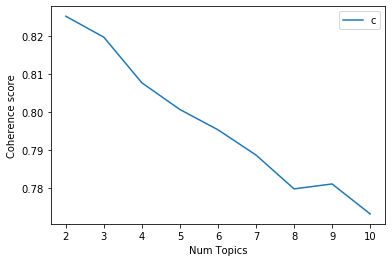

In [5]:
coherence_values = []
model_list = []
for num_topics in range(2, 11):
    model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
    model_list.append(model)
    coherencemodel = CoherenceModel(model=model, texts=list(repo_keywords), dictionary=id2word, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())
    print('cluster number:',num_topics, 'Coherence Score',coherencemodel.get_coherence())

# Show graph
limit=11; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

### Build model with best topics

In [ ]:
# Tune model with best value
model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=2, id2word=id2word)

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=model, texts=list(repo_keywords), dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

# Show Topics
pprint(model.show_topics(formatted=False))

### Viz the data

In [7]:
# Visualize the topics
for i, model in enumerate(model_list):
    lda_model_mallet = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(model)
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda_model_mallet, corpus, id2word)
    pyLDAvis.save_html(vis, f'lda1-mallet-keyword-description-{i+2}.html')

/Users/parambole/opt/anaconda3/envs/data-mining/lib/python3.6/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/Users/parambole/opt/anaconda3/envs/data-mining/lib/python3.6/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/Users/parambole/opt/anaconda3/envs/data-mining/lib/python3.6/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
/Users/parambole/opt/anaconda3/envs/data-mining/lib/python3.6/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/Users/parambole/opt/anaconda3/envs/data-mining/lib/python3.6/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero en